## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

In [26]:
# Import section
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import binary_fill_holes as bfh
from scipy.spatial import distance
from skimage import io, morphology, measure
from skimage.measure import label, regionprops
from tabulate import tabulate


In [27]:
# Define a function to print image information
def print_image_info(img, name="Image Information"):
    """Prints key information about a given image array."""
    print(f"--- {name} ---")
    print(f"Shape: {img.shape}")
    print(f"Data type: {img.dtype}")
    print(f"Min value: {img.min()}")
    print(f"Max value: {img.max()}")
    print(f"Number of unique values: {len(np.unique(img))}")
    print("\n")

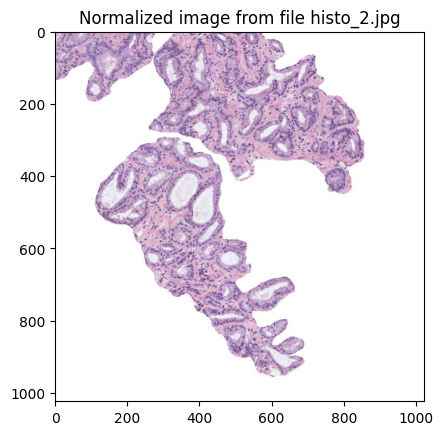

--- Original image loaded from file ---
Shape: (1024, 1024, 3)
Data type: uint8
Min value: 30
Max value: 255
Number of unique values: 224


--- Normalized image ---
Shape: (1024, 1024, 3)
Data type: float64
Min value: 0.11764705882352941
Max value: 1.0
Number of unique values: 224




In [40]:
file_number = 2 # 1 or 2
img_file = f"histo_{file_number}.jpg"

# Read file
img = io.imread(img_file)

# Normalize file to [0,1]
img_norm = img.copy().astype('uint8')/255

# Plot imgage
plt.title(f"Normalized image from file {img_file}")
plt.imshow(img_norm)
plt.show()

# Provide basic image information
print_image_info(img, "Original image loaded from file")
print_image_info(img_norm, "Normalized image")


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

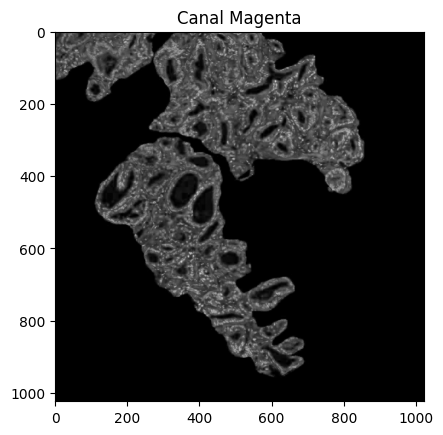

--- Normalized image used to convert to CMYK ---
Shape: (1024, 1024, 3)
Data type: float64
Min value: 0.11764705882352941
Max value: 1.0
Number of unique values: 224


--- Image converted to CMYK ---
Shape: (1024, 1024, 4)
Data type: uint8
Min value: 0
Max value: 186
Number of unique values: 182


--- Magenta Compoenent image ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 168
Number of unique values: 153




In [41]:
# 1.1 ---- Extraer la componente magenta de la imagen (que corresponde a la región tisular)

# Conversion to CMYK
with np.errstate(invalid='ignore', divide='ignore'):

    R = img_norm[:,:,0]
    G = img_norm[:,:,1]
    B = img_norm[:,:,2]

    K = 1 - np.max(img_norm, axis=2)
    # Extrae los canales de acuerdo con la ecuación del power point
    C = (1-R-K)/(1-K)
    M = (1-G-K)/(1-K)
    Y = (1-B-K)/(1-K)

# Bring together all indivudal arrays into a single four-channel image
CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
# Create the single channel images
C,M,Y,K = cv2.split(CMYK)

# 1.2 ---- Visualizar la imagen del canal magenta
plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('Canal Magenta')
plt.show()

# Provide basic image information
print_image_info(img_norm, "Normalized image used to convert to CMYK")
print_image_info(CMYK, "Image converted to CMYK")
print_image_info(M, "Magenta Compoenent image")


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

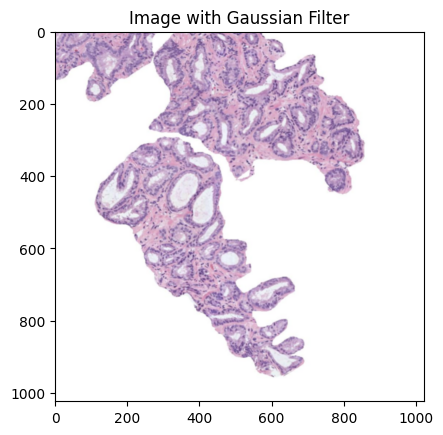

--- Original image loaded from file ---
Shape: (1024, 1024, 3)
Data type: uint8
Min value: 30
Max value: 255
Number of unique values: 224


--- Gaussian filter image ---
Shape: (1024, 1024, 3)
Data type: uint8
Min value: 54
Max value: 255
Number of unique values: 200




In [42]:
# 2.1 ---- Aplicar un filtro gaussiano de tamaño 5x5

# The question does not clarify whether the filter shold be on the original image, the normalized image or the CMYK image
# I will use the original image loaded with skimage.io in rgb format and apply gaussian

# Apply 5x5 Gaussian filter
img_gaus = cv2.GaussianBlur(img, (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.title('Image with Gaussian Filter')
plt.imshow(img_gaus)
plt.show()

print_image_info(img, "Original image loaded from file")
print_image_info(img_gaus, "Gaussian filter image")


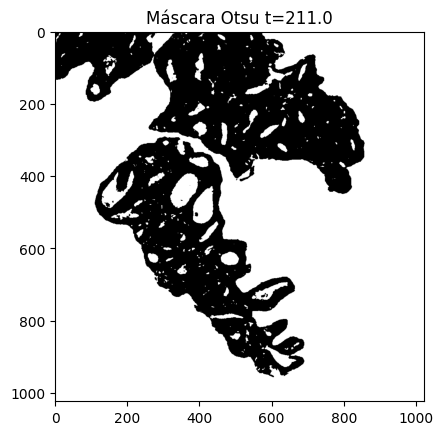

--- Guassian image used to apply OTSU ---
Shape: (1024, 1024, 3)
Data type: uint8
Min value: 54
Max value: 255
Number of unique values: 200


--- Gaussian filter image in grayscale ---
Shape: (1024, 1024)
Data type: uint8
Min value: 72
Max value: 255
Number of unique values: 182


--- Gaussian image in grayscale with OTSU method - Normalized to [0,1] ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 1
Number of unique values: 2


Background pixel value: 1


In [43]:
# 2.2 ---- utilizar el método de Otsu de manera que los píxeles
#   correspondientes al lumen y al background de la imagen sean 1s
#   y el resto de los píxeles tengan un valor de 0.

# Convert the guassian image to gray
img_gaus_gray = cv2.cvtColor(img_gaus, cv2.COLOR_BGR2GRAY)

# Obtain OTSU mask
# 0 is for black, and 1 is for white
# the mask image where pixels are either 0 (black) or 1 (white)
t, img_otsu_mask = cv2.threshold(img_gaus_gray,0,1,cv2.THRESH_OTSU)

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(img_otsu_mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

print_image_info(img_gaus, "Guassian image used to apply OTSU")
print_image_info(img_gaus_gray, "Gaussian filter image in grayscale")
print_image_info(img_otsu_mask, "Gaussian image in grayscale with OTSU method - Normalized to [0,1]")

print(f"Background pixel value: {img_otsu_mask[1000,1000]}")


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

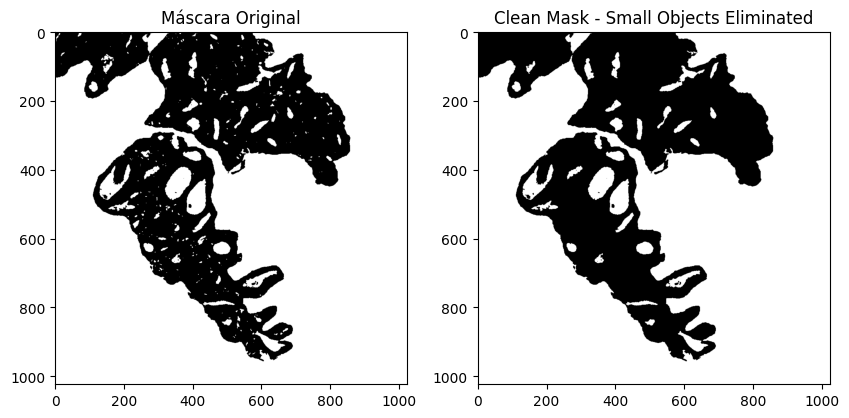

--- Gaussian grayscale with OTSU before elimination of small objects ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 1
Number of unique values: 2


--- Gaussian grayscale with OTSU with small objects eliminated ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2




In [44]:
# Convert the mask to boolean and eliminate small objects with min_size=300
# remove_small_objects only works with boolean images
img_otsu_clean = morphology.remove_small_objects(img_otsu_mask.astype(bool), min_size=300)

# Convert it back to uint8
img_otsu_clean = img_otsu_clean.astype(np.uint8) * 255

# Visualize the masks to see the result
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(img_otsu_mask, cmap='gray')
ax[0].set_title('Máscara Original')

ax[1].imshow(img_otsu_clean, cmap='gray')
ax[1].set_title('Clean Mask - Small Objects Eliminated')

plt.show()

print_image_info(img_otsu_mask, "Gaussian grayscale with OTSU before elimination of small objects")
print_image_info(img_otsu_clean, "Gaussian grayscale with OTSU with small objects eliminated")


In [45]:
# This is an additional code to provide number of objects with less than 300 pixels in the previous image

# Calculate the number of regions with less than 300 pixels
# and the number of regios with more or equal to 300 pixels

# Label image objects
label_image = measure.label(img_otsu_mask)

# Get properties for each labeled object
regions = measure.regionprops(label_image)

# Initialize counters
small_regions = 0
large_regions = 0

# Iterate through each detected region and count based on area
for region in regions:
    if region.area < 300:
        small_regions += 1
    else:
        large_regions += 1

# Print the final counts
print(f"Regions with less than 300 pixels: {small_regions}")
print(f"Regions with more or equal to 300 pixels: {large_regions}")

Regions with less than 300 pixels: 277
Regions with more or equal to 300 pixels: 29


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

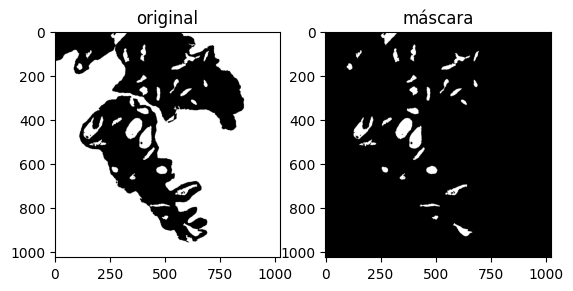

--- Gaussian grayscale with OTSU with small objects eliminated as input image ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2


--- New image with region growing technique to highlight lumens only ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2




In [46]:
# Crear una copia de la imagen
img_otsu_clean_expansion = img_otsu_clean.copy()

# Definir una imagen negra de referencia
h, w = img_otsu_clean.shape
ref = np.zeros((h+2, w+2), np.uint8)

seed1 = (0,0) # first seed on the top left corner
seed2 = (h-1, w-1) # second seed on the bottom right corner

cv2.floodFill(img_otsu_clean_expansion, ref, seed1, 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(img_otsu_clean_expansion, ref, seed2, 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_otsu_clean, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(img_otsu_clean_expansion, cmap='gray'), ax[1].set_title('máscara')
plt.show()

print_image_info(img_otsu_clean, "Gaussian grayscale with OTSU with small objects eliminated as input image")
print_image_info(img_otsu_clean_expansion, "New image with region growing technique to highlight lumens only")

#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

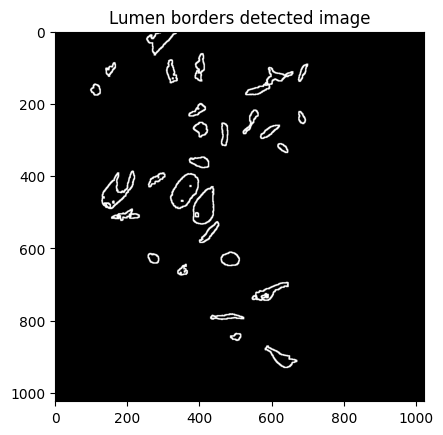

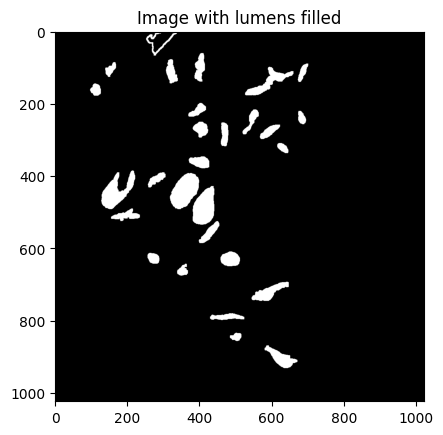

--- Gaussian grayscale with OTSU, small objects eliminated and only lumens ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2


--- New image with region growing technique to highlight lumens only ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2


--- Image with Lumens filled ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2




In [47]:
# 5.0 ---- We first apply Canny method to detect borders of objects
img_canny = cv2.Canny(img_otsu_clean_expansion, 255/3, 255) # minValue and maxValue. Canny recomienda que minValue sea 3 veces mayor que maxValue
kernel = np.ones((2,2), 'uint8')
img_canny = cv2.dilate(img_canny, kernel, iterations=3)

plt.imshow(img_canny, cmap='gray')
plt.title('Lumen borders detected image')
plt.show()

# Rellenar objetos (solo rellena si no están en contacto con el límite de la imagen)

img_borders = img_canny.copy()
filled_borders = bfh(img_borders).astype(np.uint8) * 255

plt.imshow(filled_borders, cmap='gray')
plt.title('Image with lumens filled')
plt.show()

print_image_info(img_otsu_clean_expansion, "Gaussian grayscale with OTSU, small objects eliminated and only lumens")
print_image_info(img_canny, "New image with region growing technique to highlight lumens only")
print_image_info(filled_borders, "Image with Lumens filled")


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

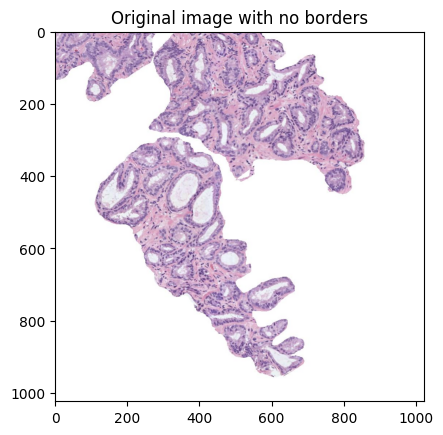

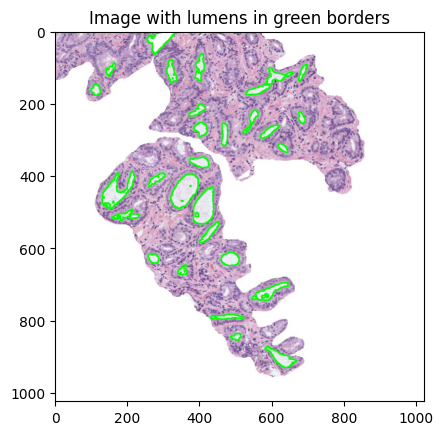

--- Original RGB image ---
Shape: (1024, 1024, 3)
Data type: uint8
Min value: 30
Max value: 255
Number of unique values: 224


--- Image with lumens in green borders ---
Shape: (1024, 1024, 3)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 225




In [48]:
# 6.1 ---- Code to apply borders to the original image ---
# Since img was created with skimage.io, it is already in RGB format
img_lumen_green_borders = img.copy()

# Find the coordinates of the border pixels (where the value is > 0)
rows, cols = np.where(img_canny > 0)

# Set the BGR values of these pixels to green (0, 255, 0)
img_lumen_green_borders[rows, cols, 0] = 0   # Red channel
img_lumen_green_borders[rows, cols, 1] = 255 # Green channel
img_lumen_green_borders[rows, cols, 2] = 0    # Blue channel

plt.imshow(img)
plt.title('Original image with no borders')
plt.show()

# 6.2 ---- Display the final image
plt.imshow(img_lumen_green_borders)
plt.title('Image with lumens in green borders')
plt.show()

print_image_info(img, "Original RGB image")
print_image_info(img_lumen_green_borders, "Image with lumens in green borders")

#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

7.1---- Largest lumen determination:
The largest lumen corresponds to label number 18
This lumen has an area of: 4679.0 pixels



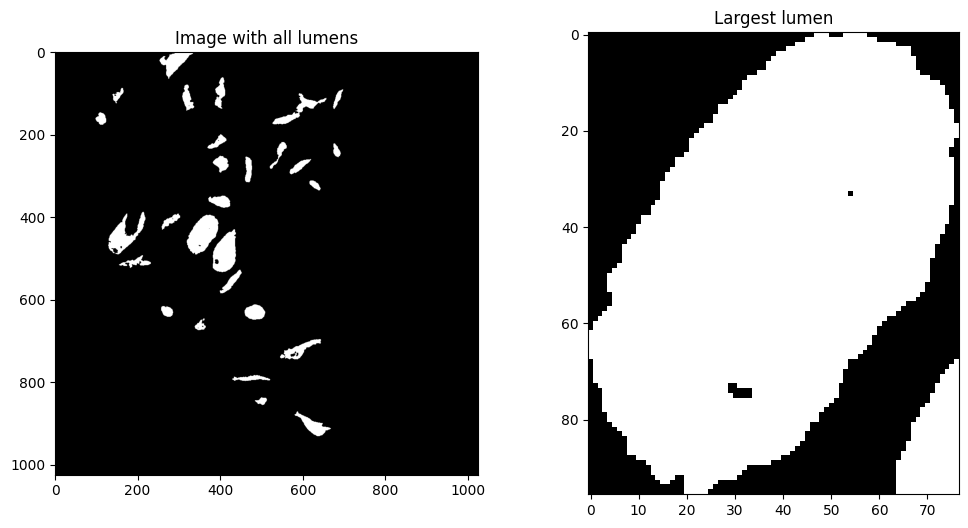

--- Gaussian grayscale with OTSU, small objects eliminated and only lumens ---
Shape: (1024, 1024)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2


--- Largest lumen ---
Shape: (96, 77)
Data type: uint8
Min value: 0
Max value: 255
Number of unique values: 2




In [49]:
# 7.1 ---- Identify larger lumen
# Obtain label for all objects, and their properties
# Label image objects

mask = img_otsu_clean_expansion.copy()
labeled_image = label(mask)
regions = regionprops(labeled_image)

largest_area = 0
largest_label = 0

for region in regions:
    if region.area > largest_area:
        largest_area = region.area
        largest_label = region.label
        largest_region = region

print("7.1---- Largest lumen determination:")
print(f"The largest lumen corresponds to label number {largest_label}")
print(f"This lumen has an area of: {largest_area} pixels")
print()

min_row, min_col, max_row, max_col = largest_region.bbox
cropped_lumen = img_otsu_clean_expansion[min_row:max_row, min_col:max_col]


# Display the resulting mask
figs, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img_otsu_clean_expansion, cmap='gray'), ax[0].set_title('Image with all lumens')
ax[1].imshow(cropped_lumen, cmap='gray'), ax[1].set_title('Largest lumen')
plt.show()

print_image_info(img_otsu_clean_expansion, "Gaussian grayscale with OTSU, small objects eliminated and only lumens")
print_image_info(cropped_lumen, "Largest lumen")

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [38]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [50]:
props = regionprops(cropped_lumen.astype(np.uint8))
lumen_properties = props[0]
#print(dir(lumen_properties))
# --- 3. Calculate and print the statistics ---
print("--- Largest lumen statistics ---")
print(f"1) Área                   : {lumen_properties.area:12.4f}")
print(f"2) Área de la bounding box: {lumen_properties.area_bbox:12.4f}")
print(f"3) Área convexa           : {lumen_properties.area_convex:12.4f}")
print(f"4) Excentricidad          : {lumen_properties.eccentricity:12.4f}")
print(f"5) Diámetro equivalente   : {lumen_properties.equivalent_diameter_area:12.4f}")
print(f"6) Extensión              : {lumen_properties.extent:12.4f}")
print(f"7) Diámetro Feret (max)   : {lumen_properties.feret_diameter_max:12.4f}")
print(f"8) Longitud del eje mayor : {lumen_properties.axis_major_length:12.4f}")
print(f"9) Longitud del eje menor : {lumen_properties.axis_minor_length:12.4f}")
print(f"10) Orientación           : {lumen_properties.orientation:12.4f}")
print(f"11) Perímetro             : {lumen_properties.perimeter:12.4f}")
print(f"12) Solidez               : {lumen_properties.solidity:12.4f}")

# For compacity, since regionprops does not provide this information
# I´ll use information from https://asignatura.us.es/imagendigital/Tema6_Descripcion_reconocimiento.pdf
# where compacidad = perimetro^2 / area
compacidad = np.round(lumen_properties.perimeter**2 / lumen_properties.area)
print(f"13) Compacidad            : {compacidad:12.4f}")

--- Largest lumen statistics ---
1) Área                   :    4924.0000
2) Área de la bounding box:    7392.0000
3) Área convexa           :    6030.0000
4) Excentricidad          :       0.7383
5) Diámetro equivalente   :      79.1797
6) Extensión              :       0.6661
7) Diámetro Feret (max)   :     104.3168
8) Longitud del eje mayor :     103.4126
9) Longitud del eje menor :      69.7448
10) Orientación           :      -0.4672
11) Perímetro             :     381.2620
12) Solidez               :       0.8166
13) Compacidad            :      30.0000
